In [2]:
%load_ext autoreload
%autoreload 2

In [267]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# (A) Nearest Stations

In [6]:
cd geocoding/

/Users/mohiuddi/Desktop/Courses/ADA/solarity/geocoding


In [7]:
import geocoding_functions as geo_fns
import location_functions as loc_fns
import station_info

## User input

In [300]:
address = "DubendorfStrasse 119, 8051 Zurich"

## Parameters

In [301]:
k = 3 ##Number of nearest neighbours

### Get coordinates of the address

In [302]:
coordinates = geo_fns.getCoordinates(address)
if(coordinates is None):
    print("*** Invalid Address ***")
    print("Sample address: Route Cantonale 33, 1025 St. Sulpice")
    exit(0)

In [303]:
coordinates

(47.4025356, 8.5791568)

### Read pickled station info

In [12]:
station_df = pickle.load(open("station_df.p","rb"))

In [13]:
station_df.head()

,name,lat,lng
0,VSVER,46.233333,7.550000
1,VSCOL,46.183333,7.383333
2,AIG,46.333333,6.916667
3,DEM,47.350000,7.350000
4,SRS,46.983333,9.666667


### Get k nearest stations and their weights

In [14]:
neighbourNames = loc_fns.get_k_nearest_neighbours(coordinates, k, station_df)
neighbourWeights = loc_fns.get_weights_for_k_nearest(coordinates, k, station_df)

In [17]:
cd ..

/Users/mohiuddi/Desktop/Courses/ADA/solarity


# (B) Solar potential

In [304]:
means = pickle.load(open('learning/groupedStations.p', 'rb'))

In [305]:
def get_monthly_power_potential(stations, weights, means):
    potential = 0
    for i in range(len(stations)):
        potential = potential + means.power[stations[i]].get_values()*weights[i]
    return potential

In [306]:
monthly_potential = get_monthly_power_potential(neighbourNames.get_values(), neighbourWeights, means)

In [307]:
potential = np.mean(np.array(monthly_potential)) ## in Wp
potential

0.13263507493695473

# (C) Installation Costs

## User input

In [363]:
averageElectricityBill = np.array([80]) ## CHF
roofArea = 30 ## m2

## Parameters

#### Electricity

In [343]:
elecTarrif = 0.20 ##CHF/Kwh

#### Solar

In [344]:
capacityPerPanel = 255 ## Wp
costPerPanel = 500 ## CHF
panelArea = 1.62 ## m2

## Average Consumption

In [345]:
hours = 24
days = 30
milli = 1000

In [346]:
avgEnergy = averageElectricityBill/elecTarrif
avgEnergy

array([ 1500.])

In [347]:
avgPower = avgEnergy/(hours*days) ## Kw
avgPower

array([ 2.08333333])

## Solar Cost and Capacity

In [348]:
installation = np.array(range(5,101,5))/100

In [349]:
numPanels = np.floor(roofArea/panelArea)

In [350]:
capacity = installation*numPanels*capacityPerPanel/1000 ## Kwp
cost = installation*numPanels*costPerPanel ## CHF
solarPower = capacity*potential ## in Kw

### Finding suitable installations

In [351]:
indx = solarPower <= avgPower ## Should this be 1 or what?
installationFinal = installation[indx]
installCapacity = capacity[indx]
installCost = cost[indx]
installPower = solarPower[indx]

In [352]:
solar_df = pd.DataFrame()
solar_df['capacity'] = installCapacity
solar_df['cost'] = installCost
solar_df['power'] = installPower
solar_df['installation'] = installationFinal
solar_df = solar_df.set_index('installation')
solar_df

,capacity,cost,power
installation,,,
0.05,1.41525,2775.0,0.187712
0.10,2.83050,5550.0,0.375424
0.15,4.24575,8325.0,0.563135
0.20,5.66100,11100.0,0.750847
0.25,7.07625,13875.0,0.938559
0.30,8.49150,16650.0,1.126271
0.35,9.90675,19425.0,1.313983
0.40,11.32200,22200.0,1.501694
0.45,12.73725,24975.0,1.689406


# (D) Savings and break-even time

In [353]:
def get_new_bill(bill, power):
    avgEnergyUsed = bill/elecTarrif
    avgEnergyUsed_daytime = avgEnergyUsed/2
    nightUsage = avgEnergyUsed/2

    avgEnergyProduced = power*hours*days
    
    newBill = np.empty(len(power))
    newUsageFromUtility = np.empty(len(power))
    for i in range(len(power)):
        dayUsage = max(0, avgEnergyUsed_daytime - avgEnergyProduced[i])
        newUsageFromUtility[i] = dayUsage + nightUsage
        newBill[i] = newUsageFromUtility[i]*elecTarrif

    return newBill, newUsageFromUtility

In [354]:
newBill, newUsage = get_new_bill(averageElectricityBill, installPower)

In [355]:
totalYears = 25
monthsInAYear = 12
def get_cummulative_savings(oldBill, newBill, cost):
    months = range(1, totalYears*monthsInAYear + 1)
    savings = np.empty((len(newBill), len(months)))
    for i in range(len(newBill)):
        eachMonth = oldBill - newBill[i]
        savings[i,:] = eachMonth*months - cost[i]
    return savings

In [356]:
savings = get_cummulative_savings(averageElectricityBill, newBill, installCost)

In [357]:
finalSavings = savings[:,-1]

In [358]:
def get_break_even_time(savings):
    nInstalls = savings.shape[0]
    breakEven = np.empty(nInstalls)
    for i in range(nInstalls):
        breakEven[i] = np.argmax(savings[i,:] > 0)

    return breakEven

In [359]:
breakEven = get_break_even_time(savings)/12

### Prettify Result

In [360]:
newBill

array([ 272.96950227,  245.93900454,  218.9085068 ,  191.87800907,
        164.84751134,  150.        ,  150.        ,  150.        ,
        150.        ,  150.        ,  150.        ])

In [361]:
final_df = solar_df
final_df['breakEvenYears'] = breakEven
final_df['savings_after_25yrs'] = finalSavings
final_df['annual_savings'] = finalSavings/totalYears
final_df

,capacity,cost,power,breakEvenYears,savings_after_25yrs,annual_savings
installation,,,,,,
0.05,1.41525,2775.0,0.187712,8.500000,5334.149320,213.365973
0.10,2.83050,5550.0,0.375424,8.500000,10668.298639,426.731946
0.15,4.24575,8325.0,0.563135,8.500000,16002.447959,640.097918
0.20,5.66100,11100.0,0.750847,8.500000,21336.597278,853.463891
0.25,7.07625,13875.0,0.938559,8.500000,26670.746598,1066.829864
0.30,8.49150,16650.0,1.126271,9.250000,28350.000000,1134.000000
0.35,9.90675,19425.0,1.313983,10.750000,25575.000000,1023.000000
0.40,11.32200,22200.0,1.501694,12.333333,22800.000000,912.000000
0.45,12.73725,24975.0,1.689406,13.833333,20025.000000,801.000000


### Plot savings

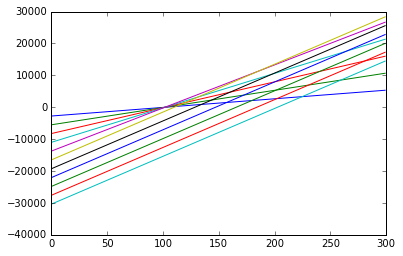

In [362]:
for i in range(savings.shape[0]):
    plt.plot(savings[i,:])